<a href="https://colab.research.google.com/github/MrGLC/Model-Pipeline/blob/main/Servicio_social_Creacion_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
def cargar_datos(ruta_archivo, columna_objetivo, columnas_a_eliminar):
    """
    Carga los datos del archivo CSV y prepara las variables dependientes e independientes.

    Parámetros:
    ruta_archivo (str): Ruta al archivo CSV con los datos.
    columna_objetivo (str): Nombre de la columna objetivo (variable dependiente).
    columnas_a_eliminar (list): Lista de columnas a eliminar del conjunto de datos.

    Retorna:
    tuple: Variables independientes (X) y dependiente (y).
    """
    # Cargamos los datos del archivo CSV
    datos_completos = pd.read_csv(ruta_archivo, sep=';')
    variable_dependiente = datos_completos[columna_objetivo]
    variables_independientes = datos_completos.drop(columns=columnas_a_eliminar + [columna_objetivo])
    return variables_independientes, variable_dependiente

In [ ]:
def aumentar_datos(variables_independientes, variable_dependiente, muestras_objetivo_por_clase, media_ruido, desviacion_estandar_ruido):
    """
    Aumenta los datos de las clases minoritarias para balancear el conjunto de datos.

    Parámetros:
    variables_independientes (DataFrame): Variables independientes originales.
    variable_dependiente (Series): Variable dependiente original.
    muestras_objetivo_por_clase (int): Número objetivo de muestras por clase después del aumento.
    media_ruido (float): Media del ruido a añadir.
    desviacion_estandar_ruido (float): Desviación estándar del ruido a añadir.

    Retorna:
    tuple: Variables independientes y dependiente aumentadas.
    """
    clases, conteos = np.unique(variable_dependiente, return_counts=True)
    variables_independientes_aumentadas = variables_independientes.copy()
    variable_dependiente_aumentada = variable_dependiente.copy()

    for clase, conteo in zip(clases, conteos):
        if conteo < muestras_objetivo_por_clase:
            variables_independientes_clase = variables_independientes[variable_dependiente == clase]
            muestras_a_generar = muestras_objetivo_por_clase - conteo

            for _ in range(muestras_a_generar):
                indice_aleatorio = np.random.randint(0, len(variables_independientes_clase))
                muestra_original = variables_independientes_clase.iloc[indice_aleatorio].values
                ruido = desviacion_estandar_ruido * np.random.randn(len(muestra_original)) + media_ruido
                nueva_muestra = pd.DataFrame([muestra_original + ruido], columns=variables_independientes.columns)

                variables_independientes_aumentadas = pd.concat([variables_independientes_aumentadas, nueva_muestra], ignore_index=True)
                variable_dependiente_aumentada = np.append(variable_dependiente_aumentada, clase)

    return variables_independientes_aumentadas, variable_dependiente_aumentada

In [ ]:
def preparar_datos(variables_independientes, variable_dependiente, aumentar_datos_activado, muestras_objetivo_por_clase, media_ruido, desviacion_estandar_ruido):
    """
    Prepara los datos para el entrenamiento, incluyendo aumento de datos, codificación de la variable dependiente,
    cálculo de pesos de clases, división de datos y escalado.

    Parámetros:
    variables_independientes (DataFrame): Variables independientes.
    variable_dependiente (Series): Variable dependiente.
    aumentar_datos_activado (bool): Si se debe realizar aumento de datos.
    muestras_objetivo_por_clase (int): Número objetivo de muestras por clase después del aumento.
    media_ruido (float): Media del ruido para el aumento de datos.
    desviacion_estandar_ruido (float): Desviación estándar del ruido para el aumento de datos.

    Retorna:
    tuple: Datos de entrenamiento y prueba preparados, pesos de clases y escalador.
    """
    if aumentar_datos_activado:
        variables_independientes, variable_dependiente = aumentar_datos(
            variables_independientes, variable_dependiente,
            muestras_objetivo_por_clase, media_ruido, desviacion_estandar_ruido
        )

    # Convertimos la variable dependiente a formato categorical
    variable_dependiente_codificada = keras.utils.to_categorical(variable_dependiente)

    # Calculamos los pesos para cada clase
    clases_unicas = np.unique(variable_dependiente)
    pesos_clases = compute_class_weight('balanced', classes=clases_unicas, y=variable_dependiente)
    diccionario_pesos_clases = dict(enumerate(pesos_clases))

    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
        variables_independientes, variable_dependiente_codificada,
        test_size=0.2, stratify=variable_dependiente, random_state=42
    )

    # Estandarizamos los datos
    escalador = StandardScaler()
    X_entrenamiento_escalado = escalador.fit_transform(X_entrenamiento)
    X_prueba_escalado = escalador.transform(X_prueba)

    return X_entrenamiento_escalado, X_prueba_escalado, y_entrenamiento, y_prueba, diccionario_pesos_clases, escalador


In [ ]:
def crear_modelo_red_neuronal(forma_entrada, numero_clases, neuronas_por_capa):
    """
    Crea un modelo de red neuronal.

    Parámetros:
    forma_entrada (int): Número de características de entrada.
    numero_clases (int): Número de clases de salida.
    neuronas_por_capa (list): Lista con el número de neuronas para cada capa oculta.

    Retorna:
    Model: Modelo de red neuronal.
    """
    modelo = keras.Sequential([
        keras.layers.Dense(neuronas_por_capa[0], activation='relu', input_shape=(forma_entrada,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(neuronas_por_capa[1], activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(neuronas_por_capa[2], activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(numero_clases, activation='softmax')
    ])
    return modelo

In [ ]:
def crear_modelo_arbol_decision(profundidad_maxima):
    """
    Crea un modelo de árbol de decisión.

    Parámetros:
    profundidad_maxima (int): Profundidad máxima del árbol.

    Retorna:
    DecisionTreeClassifier: Modelo de árbol de decisión.
    """
    return DecisionTreeClassifier(max_depth=profundidad_maxima, random_state=42)

In [ ]:
def crear_modelo_bosque_aleatorio(numero_estimadores, profundidad_maxima):
    """
    Crea un modelo de bosque aleatorio (Random Forest).

    Parámetros:
    numero_estimadores (int): Número de árboles en el bosque.
    profundidad_maxima (int): Profundidad máxima de los árboles.

    Retorna:
    RandomForestClassifier: Modelo de bosque aleatorio.
    """
    return RandomForestClassifier(n_estimators=numero_estimadores, max_depth=profundidad_maxima, random_state=42)


In [ ]:
def entrenar_modelo(modelo, X_entrenamiento, y_entrenamiento, X_prueba, y_prueba, diccionario_pesos_clases, tipo_modelo, epocas, tamano_lote):
    """
    Entrena el modelo especificado.

    Parámetros:
    modelo: Modelo a entrenar.
    X_entrenamiento, y_entrenamiento: Datos de entrenamiento.
    X_prueba, y_prueba: Datos de prueba.
    diccionario_pesos_clases (dict): Pesos de las clases.
    tipo_modelo (str): Tipo de modelo ('nn', 'dt', o 'rf').
    epocas (int): Número de épocas para el entrenamiento (solo para redes neuronales).
    tamano_lote (int): Tamaño del lote para el entrenamiento (solo para redes neuronales).

    Retorna:
    History o None: Historia del entrenamiento para redes neuronales, None para otros modelos.
    """
    if tipo_modelo == 'nn':
        detener_temprano = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        historia_entrenamiento = modelo.fit(
            X_entrenamiento, y_entrenamiento,
            epochs=epocas,
            batch_size=tamano_lote,
            validation_data=(X_prueba, y_prueba),
            class_weight=diccionario_pesos_clases,
            callbacks=[detener_temprano]
        )
        return historia_entrenamiento
    else:
        modelo.fit(X_entrenamiento, np.argmax(y_entrenamiento, axis=1))
        return None

In [ ]:
def evaluar_modelo(modelo, X_prueba, y_prueba, tipo_modelo):
    """
    Evalúa el modelo entrenado.

    Parámetros:
    modelo: Modelo entrenado.
    X_prueba, y_prueba: Datos de prueba.
    tipo_modelo (str): Tipo de modelo ('nn', 'dt', o 'rf').

    Retorna:
    float: Precisión del modelo en los datos de prueba.
    """
    if tipo_modelo == 'nn':
        perdida_prueba, precision_prueba = modelo.evaluate(X_prueba, y_prueba)
        print(f"Precisión de prueba: {precision_prueba:.4f}, pérdida de prueba: {perdida_prueba:.4f}")
    else:
        precision_prueba = modelo.score(X_prueba, np.argmax(y_prueba, axis=1))
        print(f"Precisión de prueba: {precision_prueba:.4f}")
    return precision_prueba

In [ ]:
def graficar_matriz_confusion(y_verdadero, y_predicho, clases):
    """
    Grafica la matriz de confusión del modelo.

    Parámetros:
    y_verdadero: Etiquetas verdaderas.
    y_predicho: Predicciones del modelo.
    clases: Lista de clases.
    """
    matriz_confusion = confusion_matrix(y_verdadero, y_predicho)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz de Confusión - Precisión: {accuracy_score(y_verdadero, y_predicho):.4f}')
    plt.show()

In [ ]:
def aplicar_pca(X, n_componentes):
    """
    Aplica PCA a las características dependientes.

    Parámetros:
    X (array): Características dependientes.
    n_componentes (int): Número de componentes principales a mantener.

    Retorna:
    array: Características transformadas por PCA.
    PCA: Objeto PCA entrenado.
    """
    pca = PCA(n_components=n_componentes)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

In [ ]:
def guardar_modelo_y_graficas(modelo, tipo_modelo, objetivo, precision, historia_entrenamiento=None):
    """
    Guarda el modelo entrenado y las gráficas asociadas.

    Parámetros:
    modelo: Modelo entrenado.
    tipo_modelo (str): Tipo de modelo ('nn', 'dt', o 'rf').
    objetivo (str): Variable objetivo del modelo.
    precision (float): Precisión del modelo.
    historia_entrenamiento: Historia del entrenamiento (solo para redes neuronales).
    """
    # Crear directorio si no existe
    directorio = f'modelos_{objetivo}'
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Guardar modelo
    if tipo_modelo == 'nn':
        modelo.save(f'{directorio}/modelo_{tipo_modelo}_{objetivo}.keras')
    else:
        joblib.dump(modelo, f'{directorio}/modelo_{tipo_modelo}_{objetivo}.joblib')

    # Guardar gráfica de precisión
    plt.figure(figsize=(10, 6))
    plt.title(f'Precisión del modelo {tipo_modelo} para {objetivo}: {precision:.4f}')
    plt.savefig(f'{directorio}/precision_{tipo_modelo}_{objetivo}.png')
    plt.close()

    # Guardar gráfica de historia de entrenamiento para redes neuronales
    if tipo_modelo == 'nn' and historia_entrenamiento is not None:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(historia_entrenamiento.history['accuracy'], label='Entrenamiento')
        plt.plot(historia_entrenamiento.history['val_accuracy'], label='Validación')
        plt.title('Precisión del Modelo')
        plt.xlabel('Época')
        plt.ylabel('Precisión')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(historia_entrenamiento.history['loss'], label='Entrenamiento')
        plt.plot(historia_entrenamiento.history['val_loss'], label='Validación')
        plt.title('Pérdida del Modelo')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'{directorio}/historia_{tipo_modelo}_{objetivo}.png')
        plt.close()

In [ ]:
def graficar_historia_entrenamiento(historia):
    """
    Grafica la historia del entrenamiento de la red neuronal.

    Parámetros:
    historia: Objeto History devuelto por el método fit() de Keras.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(historia.history['accuracy'], label='Entrenamiento')
    plt.plot(historia.history['val_accuracy'], label='Validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(historia.history['loss'], label='Entrenamiento')
    plt.plot(historia.history['val_loss'], label='Validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def ejecutar_pipeline(configuracion):
    """
    Ejecuta el pipeline completo de entrenamiento y evaluación del modelo.

    Parámetros:
    configuracion (dict): Diccionario con la configuración del pipeline.

    Retorna:
    tuple: Modelo entrenado, escalador y precisión del modelo.
    """
    # Cargamos los datos
    variables_independientes, variable_dependiente = cargar_datos(
        configuracion['archivo_csv'],
        configuracion['columna_objetivo'],
        configuracion['columnas_eliminar']
    )

    # Aplicar PCA si está activado
    if configuracion['aplicar_pca']:
        variables_independientes, pca = aplicar_pca(variables_independientes, configuracion['n_componentes_pca'])

    # Preparamos los datos
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba, diccionario_pesos_clases, escalador = preparar_datos(
        variables_independientes, variable_dependiente,
        aumentar_datos_activado=configuracion['aumento_activado'],
        muestras_objetivo_por_clase=configuracion['muestras_objetivo_por_clase'],
        media_ruido=configuracion['media_ruido'],
        desviacion_estandar_ruido=configuracion['desviacion_estandar_ruido']
    )

    # Creamos el modelo según el tipo especificado
    if configuracion['tipo_modelo'] == 'nn':
        modelo = crear_modelo_red_neuronal(X_entrenamiento.shape[1], y_entrenamiento.shape[1], configuracion['neuronas_por_capa'])
        modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif configuracion['tipo_modelo'] == 'dt':
        modelo = crear_modelo_arbol_decision(profundidad_maxima=configuracion['profundidad_arbol'])
    elif configuracion['tipo_modelo'] == 'rf':
        modelo = crear_modelo_bosque_aleatorio(
            numero_estimadores=configuracion['numero_estimadores'],
            profundidad_maxima=configuracion['profundidad_arbol']
        )
    else:
        raise ValueError(f"Tipo de modelo no reconocido: {configuracion['tipo_modelo']}")

    # Entrenamos el modelo
    historia_entrenamiento = entrenar_modelo(
        modelo, X_entrenamiento, y_entrenamiento, X_prueba, y_prueba, diccionario_pesos_clases,
        configuracion['tipo_modelo'], configuracion['epocas'], configuracion['tamano_lote']
    )

    # Evaluamos el modelo
    precision_prueba = evaluar_modelo(modelo, X_prueba, y_prueba, configuracion['tipo_modelo'])

    # Graficamos la historia del entrenamiento para la red neuronal
    if configuracion['tipo_modelo'] == 'nn' and configuracion['mostrar_grafica_entrenamiento']:
        graficar_historia_entrenamiento(historia_entrenamiento)

    # Hacemos predicciones y graficamos la matriz de confusión
    y_predicho = modelo.predict(X_prueba)
    if configuracion['tipo_modelo'] == 'nn':
        y_predicho = np.argmax(y_predicho, axis=1)

    if configuracion['mostrar_matriz_confusion']:
        graficar_matriz_confusion(np.argmax(y_prueba, axis=1), y_predicho, clases=np.unique(np.argmax(y_prueba, axis=1)))

    # Guardar modelo y gráficas si está activado
    if configuracion['guardar_modelo']:
        guardar_modelo_y_graficas(modelo, configuracion['tipo_modelo'], configuracion['columna_objetivo'], precision_prueba, historia_entrenamiento)

    return modelo, escalador, precision_prueba


Entrenando modelo para Estado materno


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4477 - loss: 1.2957 - val_accuracy: 0.7100 - val_loss: 0.8633
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6156 - loss: 0.9167 - val_accuracy: 0.7470 - val_loss: 0.7285
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6726 - loss: 0.8169 - val_accuracy: 0.7601 - val_loss: 0.6473
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6983 - loss: 0.7543 - val_accuracy: 0.7697 - val_loss: 0.6094
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.7396 - val_accuracy: 0.7780 - val_loss: 0.5911
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7332 - loss: 0.7015 - val_accuracy: 0.7816 - val_loss: 0.5772
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7475 - loss: 0.6435 - val_accuracy: 0.7792 - val_loss: 0.5658
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7683 - loss: 0.6425 - val_acc

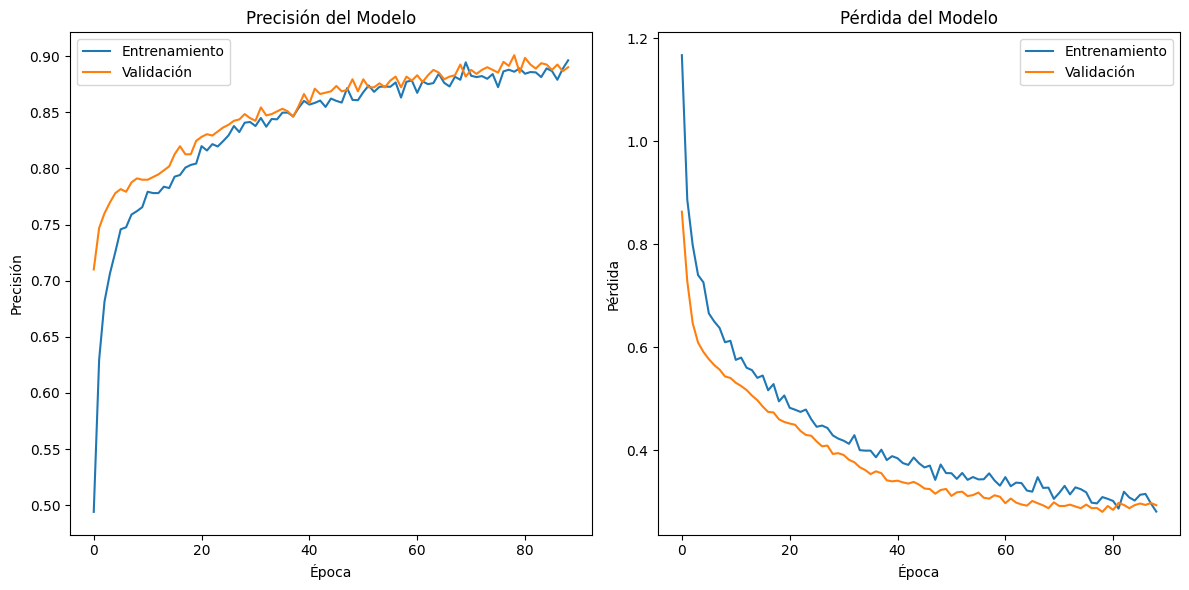

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


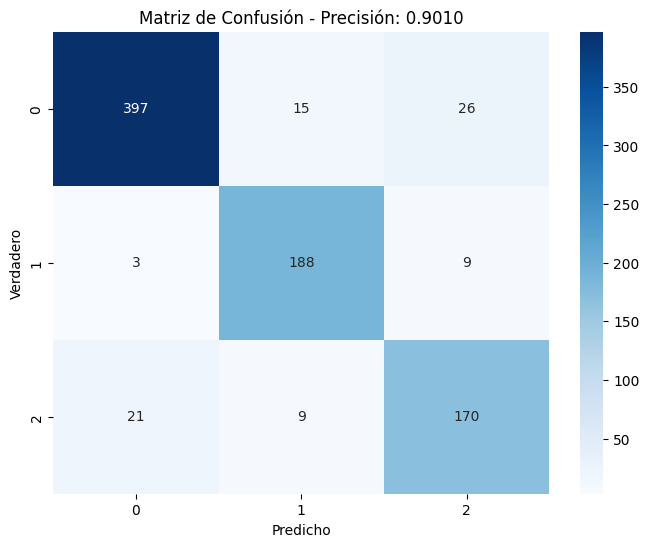

Precisión del modelo para Estado materno: 0.9010

Entrenando modelo para Estado fetal
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3145 - loss: 1.5893 - val_accuracy: 0.6626 - val_loss: 1.0425
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5584 - loss: 1.0631 - val_accuracy: 0.7713 - val_loss: 0.7358
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6570 - loss: 0.8678 - val_accuracy: 0.8163 - val_loss: 0.5828
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7223 - loss: 0.7356 - val_accuracy: 0.8322 - val_loss: 0.5034
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394 - loss: 0.6606 - val_accuracy: 0.8491 - val_loss: 0.4430
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7665 - loss: 0.5742 - val_accuracy: 0.8585 - val_loss: 0.4102
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7678 - loss: 0.5747 - val_accuracy: 0.8669 - val_loss: 0.3763
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7715 - loss: 0.5327 - val_accuracy: 0.8932

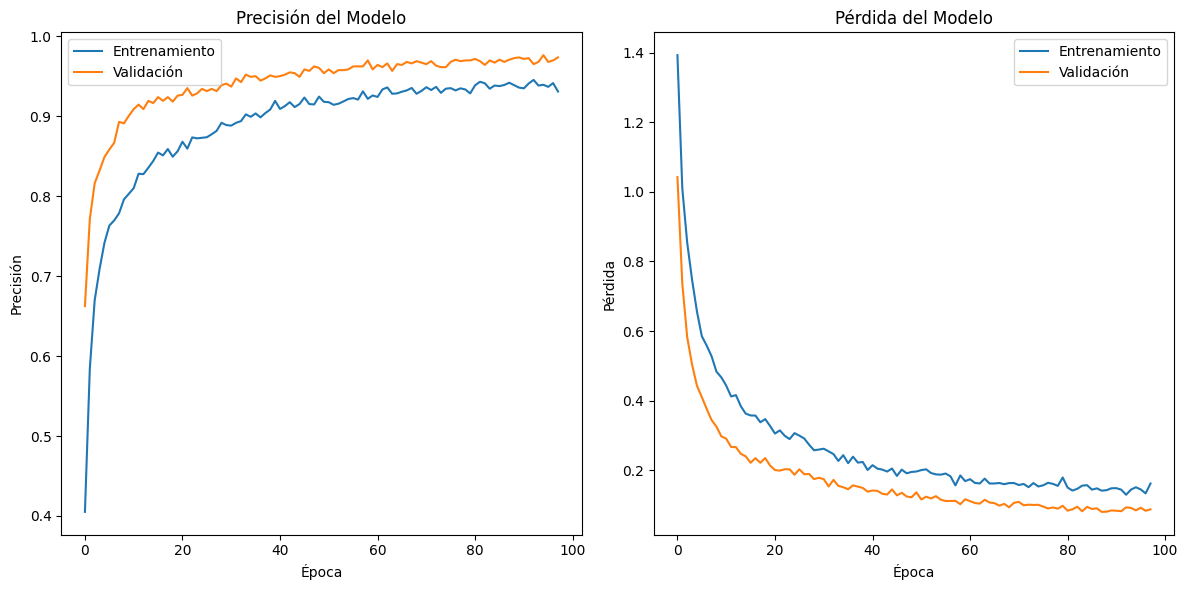

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


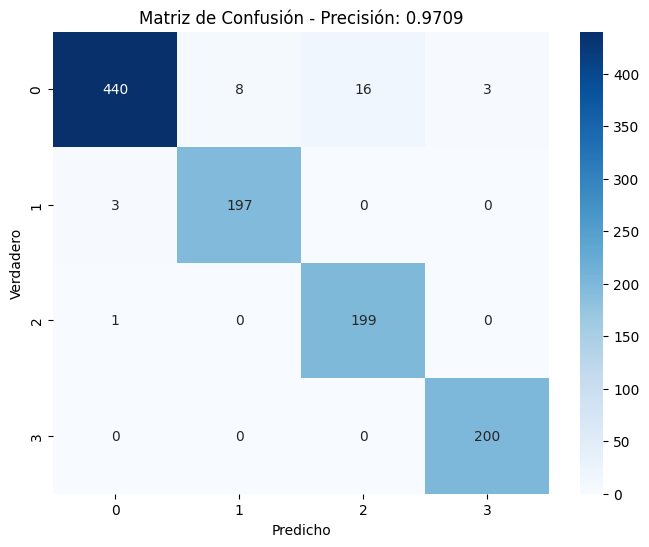

Precisión del modelo para Estado fetal: 0.9709

Entrenando modelo para Hemorragia
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2903 - loss: 2.1641 - val_accuracy: 0.5527 - val_loss: 1.3337
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5087 - loss: 1.5721 - val_accuracy: 0.6473 - val_loss: 1.0350
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5568 - loss: 1.3945 - val_accuracy: 0.6751 - val_loss: 0.8691
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6189 - loss: 1.1924 - val_accuracy: 0.7069 - val_loss: 0.7669
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6304 - loss: 1.1187 - val_accuracy: 0.7355 - val_loss: 0.7034
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6608 - loss: 1.0302 - val_accuracy: 0.7412 - val_loss: 0.6628
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6721 - loss: 0.9832 - val_accuracy: 0.7673 - val_loss: 0.6254
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6738 - loss: 0.9521 - val_accuracy: 0.7771

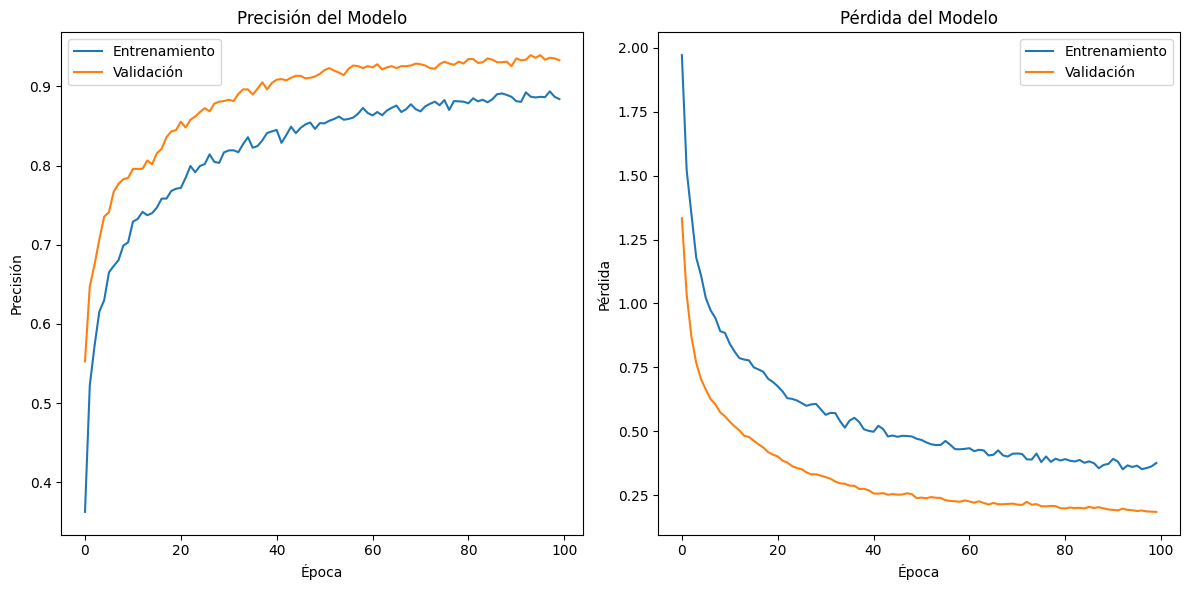

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


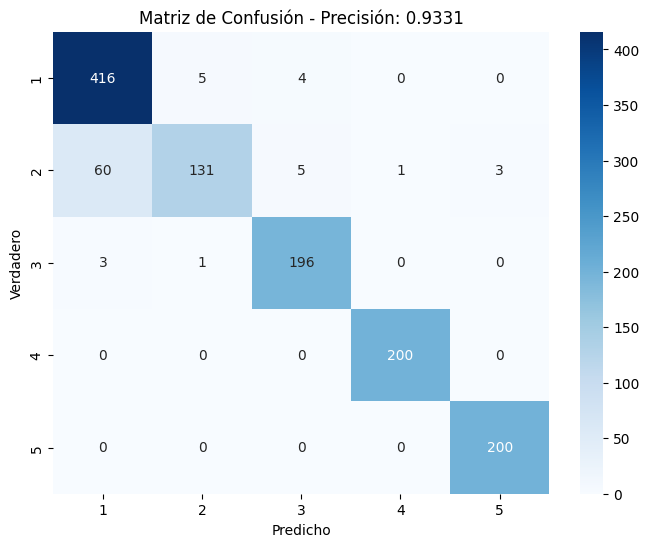

Precisión del modelo para Hemorragia: 0.9331

Entrenamiento completado para todas las variables objetivo.


In [ ]:
if __name__ == "__main__":
    # Configuración del pipeline
    configuracion = {
        # Parámetros del conjunto de datos
        'archivo_csv': 'Base de datos materna.csv',
        'columna_objetivo': 'Estado materno',  # Puede cambiarse a 'Estado fetal' o 'Hemorragia'
        'columnas_eliminar': ['Fecha', 'ID'],

        # Parámetros del modelo
        'tipo_modelo': 'nn',  # Opciones: 'nn' (Red Neuronal), 'dt' (Árbol de Decisión), 'rf' (Bosque Aleatorio)
        'neuronas_por_capa': [64, 32, 16],  # Solo para 'nn'
        'profundidad_arbol': 5,  # Para 'dt' y 'rf'
        'numero_estimadores': 100,  # Solo para 'rf'
        'epocas': 100,
        'tamano_lote': 32,

        # Parámetros de aumento de datos
        'aumento_activado': True,
        'muestras_objetivo_por_clase': 1000,  # Número objetivo de muestras por clase después del aumento
        'media_ruido': 0.0,
        'desviacion_estandar_ruido': 0.1,

        # Parámetros de visualización
        'mostrar_grafica_entrenamiento': True,
        'mostrar_matriz_confusion': True,

        # Nuevos parámetros
        'aplicar_pca': False,  # Activar/desactivar PCA
        'n_componentes_pca': 10,  # Número de componentes principales a usar si PCA está activado
        'guardar_modelo': True,  # Activar/desactivar guardado de modelo y gráficas
    }

    # Ejecutamos el pipeline para cada variable objetivo
    for objetivo in ['Estado materno', 'Estado fetal', 'Hemorragia']:
        print(f"\nEntrenando modelo para {objetivo}")
        configuracion['columna_objetivo'] = objetivo
        modelo, escalador, precision = ejecutar_pipeline(configuracion)
        print(f"Precisión del modelo para {objetivo}: {precision:.4f}")

    print("\nEntrenamiento completado para todas las variables objetivo.")